# 새와 드론 분류

In [2]:
import albumentations as A


def transform(image):
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.OneOf([
            A.ColorJitter(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5) 
        ], p=1)        
    ], p=0.5)

    return aug(image=image)['image']

idg = ImageDataGenerator(preprocessing_function=transform, rescale=1./255)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 244

train_dir = './datasets/b_d_classifier/test/'
validation_dir = './datasets/b_d_classifier/validation/'
test_dir = './datasets/b_d_classifier/test'

train_data_generator = idg
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

# 과적합 발생 시 batch size를 낮추고 과소적합 발생시 batch size를 높인다. 단, 비율에 따라서 조절할 것.
train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_data_generator.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary'
)

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 110 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
Found 110 images belonging to 2 classes.
{'bird': 0, 'drone': 1}
{'bird': 0, 'drone': 1}
{'bird': 0, 'drone': 1}


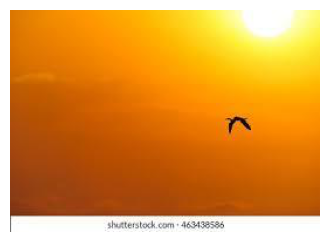

In [14]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(train_generator.filepaths[10]), cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')

show_image(image)

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2

IMAGE_SIZE = 244

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)
# x = Dropout(rate=0.5)(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
output = Dense(1, activation='softmax', kernel_initializer='glorot_normal')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 244, 244, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 244, 244, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 244, 244, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 122, 122, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 122, 122, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 122, 122, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 122, 122, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 122, 122, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 122, 122, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 31, 31, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 31, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,505 (2.10 MB)

 Trainable params: 550,353 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

In [22]:
mcp_cb = ModelCheckpoint(
    filepath='./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    mode='min',
    verbose= 1
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    verbose= 1
)

In [25]:
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks = [mcp_cb, rlr_cb]
                    # callbacks = [rlr_cb]
                   )

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - acc: 0.5553 - loss: 0.6510 - val_acc: 0.5455 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - acc: 0.5646 - loss: 0.6004 - val_acc: 0.5455 - val_loss: 1.5997 - learning_rate: 0.0010
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - acc: 0.5552 - loss: 0.5858 - val_acc: 0.5455 - val_loss: 2.1403 - learning_rate: 0.0010
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - acc: 0.5448 - loss: 0.5803 - val_acc: 0.5455 - val_loss: 3.0048 - learning_rate: 0.0010
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.5361 - loss: 0.5050
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - acc: 0.5380 - loss: 0.5071 - val_acc: 0.5455 - val_loss: 2.9705 - learning_rate: 0.0010
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - acc: 0.5706 - loss: 0.5769 - val_acc: 0.5455 - val_loss: 2.6628 - learning_rate: 1.0000e-04
Epoch 7/20
4/4 ━━━━━━━━━━━

In [ ]:
model.evaluate(test_generator, batch_size=32)

# 예측을 하지 못한다고 판단하여 추가 층 생성

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2

IMAGE_SIZE = 244

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = Conv2D(filters=64, kernel_size=3, strides=1, kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=3, strides=1, kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, strides=1, kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=128, kernel_size=3, strides=1, kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, strides=2, kernel_initializer='he_normal')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation='relu')(x)
x = Dropout(rate=0.4)(x)
output = Dense(1, activation='softmax', kernel_initializer='glorot_normal')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

In [ ]:
mcp_cb = ModelCheckpoint(
    filepath='./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    mode='min',
    verbose= 1
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    verbose= 1
)

In [ ]:
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks = [mcp_cb, rlr_cb]
                    # callbacks = [rlr_cb]
                   )